# Predictive Model

#### Packages

In [1]:
# file manipualtion
from pathlib import Path
import numpy as np
import pandas as pd

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

# visualistaion
import matplotlib.pyplot as plt

#### Directory  creation and file management

In [2]:
# defining the directory to original data
cwd = Path('./')
root_dir = cwd.resolve().parent

original_data_dir = root_dir / 'data'
additional_data_dir = root_dir / 'additional_data'

# list the .csv files for the project
for file in original_data_dir.glob('*.csv'):
    print(file)

/Volumes/GoogleDrive/My Drive/Dev/TrafficAccidents/data/accidents2019.csv
/Volumes/GoogleDrive/My Drive/Dev/TrafficAccidents/data/casualties2019.csv
/Volumes/GoogleDrive/My Drive/Dev/TrafficAccidents/data/vehicles2019.csv


#### Testing classification models

In [3]:

def get_models():
    models = {}
    models['decision_tree'] = DecisionTreeClassifier()
    models['knn'] = KNeighborsClassifier()
    models['logistic_regression'] = LogisticRegression()
    models['bayes'] = MultinomialNB()
    return models

models = get_models()

models

{'decision_tree': DecisionTreeClassifier(),
 'knn': KNeighborsClassifier(),
 'logistic_regression': LogisticRegression(),
 'bayes': MultinomialNB()}

In [4]:
# import cleaned accidents data frame from the pickle file
accidents = pd.read_pickle(additional_data_dir / 'accidents_cleaned.pkl')
vehicles = pd.read_csv(original_data_dir / 'vehicles2019.csv')
casualties = pd.read_csv(original_data_dir / 'casualties2019.csv')

# convert column names to lowercase for ease of indexing
def lower_columns(df):
    """
    Defintion:
        convert column names to lower case
    """
    df.columns = map(str.lower, df.columns)
    
# converting all column names to lower case
lower_columns(vehicles)
lower_columns(casualties)

accidents = pd.merge(accidents, vehicles, on='accident_index')
accidents = pd.merge(accidents, casualties, on='accident_index')
accidents.columns

/var/folders/j8/lt4lg_hj4b3_s5g6ft7x110r0000gn/T/ipykernel_6368/1089652144.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicles = pd.read_csv(original_data_dir / 'vehicles2019.csv')
/var/folders/j8/lt4lg_hj4b3_s5g6ft7x110r0000gn/T/ipykernel_6368/1089652144.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  casualties = pd.read_csv(original_data_dir / 'casualties2019.csv')


Index(['accident_index', 'longitude', 'latitude', 'police_force',
       'accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'day_of_week', 'local_authority_(district)',
       'local_authority_(highway)', '1st_road_class', '1st_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       '2nd_road_class', '2nd_road_number',
       'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'lsoa_of_accident_location', 'district', 'converted_date',
       'converted_time', 'datetime', 'decimal_time', 'day_of_year',
       'vehicle_reference_x', 'vehicle_type', 'towing_and_articulation',
       'vehicle_manoeuvre', 'vehicle_location-restricted_lane',
       'junction_location', 'skidding_a

# Determining columns to keep

### Test for columns with many values less than 0

Any column with more than 10% of values being less than 0 is dropped.

In [5]:
# exclude columns with non-numerical data types
test = accidents.select_dtypes(exclude=['object', 'datetime64'])

ratios = ((test < 0).sum() / test.sum()).to_dict()

to_delete = []
for k, v in ratios.items():
    if v > 0.10:
        to_delete.append(k)

print(to_delete)

['junction_control', '2nd_road_class', 'towing_and_articulation', 'propulsion_code', 'driver_home_area_type', 'casualty_home_area_type']


In [52]:
# manually determine data type of features
numeric = ['number_of_vehicles', 'number_of_casualties', 'age_of_driver',
           'engine_capacity_(cc)', 'age_of_vehicle', 'age_of_casualty']

binary = ['was_vehicle_left_hand_drive?', 'sex_of_driver', 'sex_of_casualty']

nominal = ['1st_road_class', 'road_type', 'junction_detail', 'light_conditions',
           'weather_conditions', 'road_surface_conditions',
           'urban_or_rural_area',
           'vehicle_type', 'vehicle_manoeuvre',
           'junction_location', 'journey_purpose_of_driver', 'casualty_type']

ordinal = ['speed_limit', 'day_of_week', 'day_of_year', 'age_band_of_driver', 'age_band_of_casualty']

target = 'accident_severity'

/var/folders/j8/lt4lg_hj4b3_s5g6ft7x110r0000gn/T/ipykernel_6368/1702727400.py:15: RuntimeWarning: divide by zero encountered in log
  scores = -np.log(selector.pvalues_)


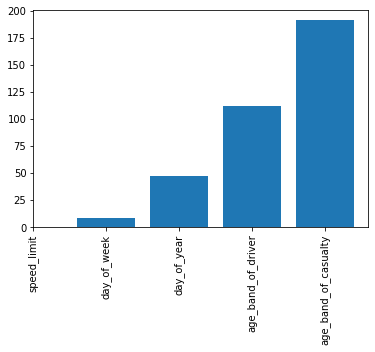

In [53]:
def select_subset(df, predictors, target):
    filtered = df.filter(predictors + [target], axis=1)
    filtered = filtered[(filtered > 0).all(1)]
    return filtered

def get_feature_scores(filterd_dataset, predictors, target, dtype='cat'):
    if (dtype=='cat'):
        selector = SelectKBest(f_classif, k='all')
    elif (dtype=='num'):
        selector = SelectKBest(f_classif, k='all')
    selector.fit(filterd_dataset[predictors], filterd_dataset[target])

    p_values = selector.pvalues_
    p_values = pd.Series(p_values)
    scores = -np.log(selector.pvalues_)
    return scores

def plot_features(scores, predictors):
    plt.bar(range(len(predictors)), scores)
    plt.xticks(range(len(predictors)), predictors, rotation='vertical')
    plt.show()

def feature_selection(df, predictors, target, dtype='cat'):
    filtered_df = select_subset(df, predictors, target)
    scores = get_feature_scores(filtered_df, predictors, target, dtype)
    plot_features(scores, predictors)

feature_selection(accidents, ordinal, target, 'cat')



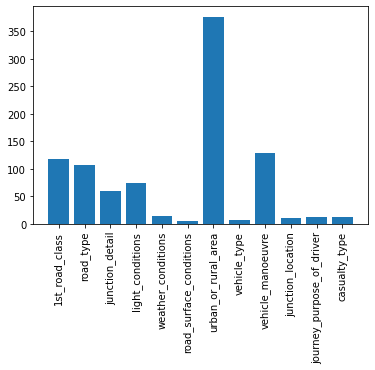

In [54]:
feature_selection(accidents, nominal, target)

/var/folders/j8/lt4lg_hj4b3_s5g6ft7x110r0000gn/T/ipykernel_6368/1702727400.py:15: RuntimeWarning: divide by zero encountered in log
  scores = -np.log(selector.pvalues_)


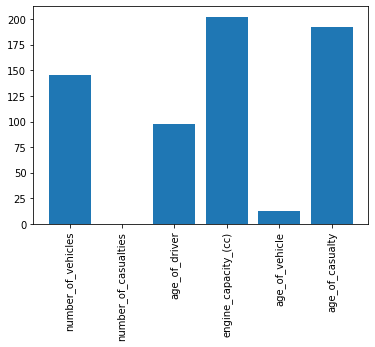

In [55]:
feature_selection(accidents, numeric, target)

# Constructing the model

In [50]:

# splitting features and labels
X_data = filtered.iloc[:, :-1]
y_data = filtered.iloc[:, -1]

# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25)

# data set shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (54127, 4)
y_train shape: (54127,)
X_test shape: (18043, 4)
y_test shape: (18043,)


#### Evaluate model

Here we use a repeated stratified k-fold cross-validation method, so that the training data is split into k folds with equal proportions per label. Each k-1 folds are evaluated using the final fold as validation, and the process is repeated three times, hence repeated stratified k-fold.

In [57]:
# testing
bayes = MultinomialNB()
scoring = ['precision_macro', 'recall_macro']
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
scores = cross_validate(bayes, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)
sorted(scores.keys())
scores['test_recall_macro']

/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jake/minicond

array([0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333])

In [95]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=1)
    return scores

results, names, summary_results = [], [], []
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    summary_results.append({name: {'mean': np.mean(results), 'std': np.std(results)}})
    print(f"{name} {np.mean(scores)cores of the estim:.4f}, {np.std(scores):.4f}")

decision_tree 0.7970, 0.0009
knn 0.7327, 0.0977


/Users/jakegodsall/miniconda3/envs/data-science/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jakegodsall/miniconda3/envs/data-science/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

logistic_regression 0.7988, 0.0000
bayes 0.7988, 0.0000


In [96]:
summary_results

[{'decision_tree': {'mean': 0.7970329076474848, 'std': 0.0008689513929717687}},
 {'knn': {'mean': 0.7648851531404486, 'std': 0.0762139364577108}},
 {'logistic_regression': {'mean': 0.7761984309700286,
   'std': 0.06425229478023006}},
 {'bayes': {'mean': 0.7818550698848187, 'std': 0.056500100266826336}}]

In [97]:
from sklearn.ensemble import StackingClassifier

def get_stacking():
    level0 = []
    for k, v in models.items():
        level0.append((k, v))
    level1 = LogisticRegression()
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

get_stacking()

StackingClassifier(cv=5,
                   estimators=[('decision_tree', DecisionTreeClassifier()),
                               ('knn', KNeighborsClassifier()),
                               ('logistic_regression', LogisticRegression()),
                               ('bayes', MultinomialNB())],
                   final_estimator=LogisticRegression())

In [98]:
models['stack'] = get_stacking()

results, names, summary_results = [], [], []
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    summary_results.append({name: {'mean': np.mean(results), 'std': np.std(results)}})
    print(f"{name} {np.mean(scores):.4f}, {np.std(scores):.4f}")

decision_tree 0.7970, 0.0009
knn 0.7327, 0.0977


/Users/jakegodsall/miniconda3/envs/data-science/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jakegodsall/miniconda3/envs/data-science/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

logistic_regression 0.7988, 0.0000
bayes 0.7988, 0.0000


/Users/jakegodsall/miniconda3/envs/data-science/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jakegodsall/miniconda3/envs/data-science/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

stack 0.7984, 0.0005


In [99]:
summary_results

[{'decision_tree': {'mean': 0.7970144313278276, 'std': 0.0008906356796618427}},
 {'knn': {'mean': 0.7648759149806199, 'std': 0.07621016534052598}},
 {'logistic_regression': {'mean': 0.7761922721968095,
   'std': 0.06425039726893583}},
 {'bayes': {'mean': 0.7818504508049043, 'std': 0.05649894439479075}},
 {'stack': {'mean': 0.7851689951744922, 'std': 0.05096870138115473}}]

In [ ]:
models